In [2]:
# Fixing certificates
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Downloading our images

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 289s 1us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


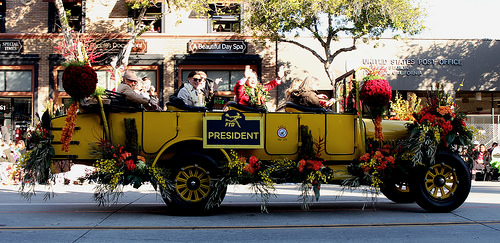

In [17]:
# (Nice picture of roses)
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [6]:
# Some parameters
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Train set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
# Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


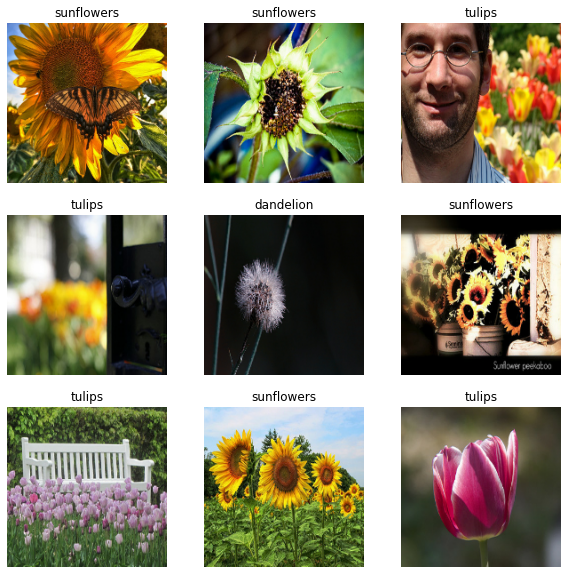

In [11]:
# First 9 images in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [21]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 43s 467ms/step - loss: 1.4217 - accuracy: 0.3920 - val_loss: 1.1770 - val_accuracy: 0.4918
Epoch 2/10
92/92 [==============================] - 39s 422ms/step - loss: 1.0602 - accuracy: 0.5698 - val_loss: 1.0484 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 40s 438ms/step - loss: 0.9312 - accuracy: 0.6369 - val_loss: 0.9212 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 42s 453ms/step - loss: 0.7425 - accuracy: 0.7258 - val_loss: 0.9960 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 42s 452ms/step - loss: 0.5379 - accuracy: 0.7984 - val_loss: 1.2648 - val_accuracy: 0.5736
Epoch 6/10
92/92 [==============================] - 40s 436ms/step - loss: 0.3667 - accuracy: 0.8723 - val_loss: 1.2440 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 40s 436ms/step - loss: 0.2179 - accuracy: 0.9240 - val_loss: 1.4145 - val_accuracy: 0.6362

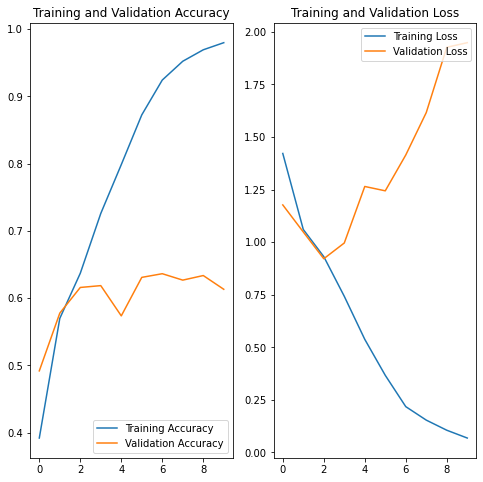

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
# There seems to be an issue with the data augmentation code
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

NotImplementedError: Cannot convert a symbolic Tensor (random_rotation_8/rotation_matrix/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [32]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 44s 479ms/step - loss: 1.3586 - accuracy: 0.4186 - val_loss: 1.0538 - val_accuracy: 0.5940
Epoch 2/15
92/92 [==============================] - 42s 459ms/step - loss: 1.0003 - accuracy: 0.6083 - val_loss: 0.9922 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 39s 428ms/step - loss: 0.8291 - accuracy: 0.6778 - val_loss: 0.9129 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 43s 462ms/step - loss: 0.6689 - accuracy: 0.7452 - val_loss: 0.9848 - val_accuracy: 0.6362
Epoch 5/15
92/92 [==============================] - 42s 459ms/step - loss: 0.4765 - accuracy: 0.8351 - val_loss: 1.0065 - val_accuracy: 0.6621
Epoch 6/15
92/92 [==============================] - 40s 430ms/step - loss: 0.2984 - accuracy: 0.8995 - val_loss: 1.1912 - val_accuracy: 0.6362
Epoch 7/15
92/92 [==============================] - 39s 427ms/step - loss: 0.1842 - accuracy: 0.9397 - val_loss: 1.3961 - val_accuracy: 0.6471

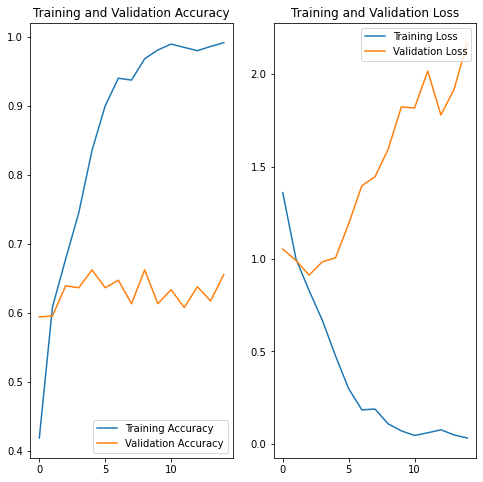

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
img_height

180